In [1]:
from ipywidgets import interact, interactive

In [2]:
import numpy as np
import scipy.integrate
import scipy.optimize

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
#sns.set(style='whitegrid', context='notebook', palette=colors, 
#        rc={'axes.labelsize': 16})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [32]:
ts = np.arange(0,10,.5)
ts

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

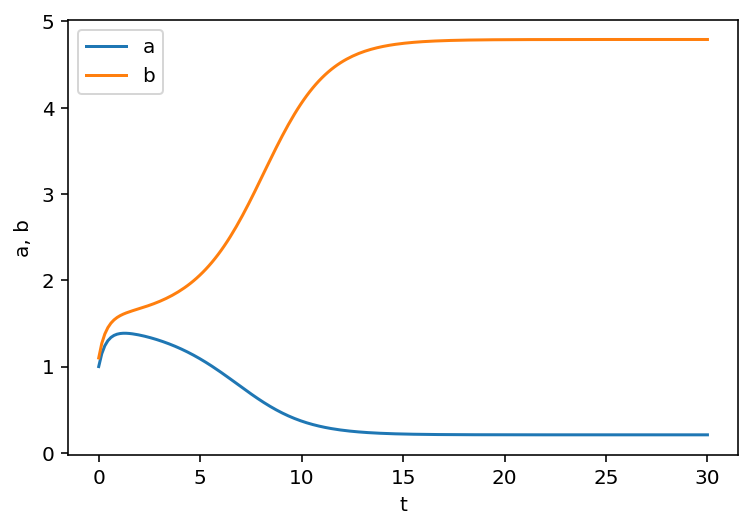

In [33]:
def toggle(ab, t, beta, gamma, n):
    """Right hand side for toggle ODEs."""
    a, b = ab
    return np.array([beta / (1 + b**n) - a,
                     gamma * (beta / (1 + a**n) - b)])

# Parameters
gamma = 1
beta = 5
n = 2
args = (beta, gamma, n)

# Initial condition
ab0 = np.array([1, 1.1])

# Solve
t = np.linspace(0, 30, 200)
ab = scipy.integrate.odeint(toggle, ab0, t, args=args)

# Plot
plt.plot(t, ab)
plt.xlabel('t')
plt.ylabel('a, b')
plt.legend(('a', 'b'));

In [35]:
ab.shape

(200, 2)

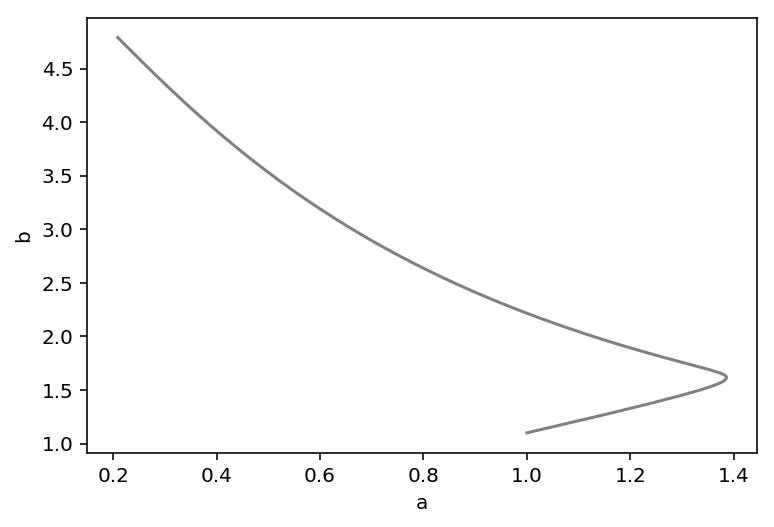

In [4]:
# Plot
plt.plot(ab[:,0], ab[:,1], color='gray')
plt.xlabel('a')
plt.ylabel('b');

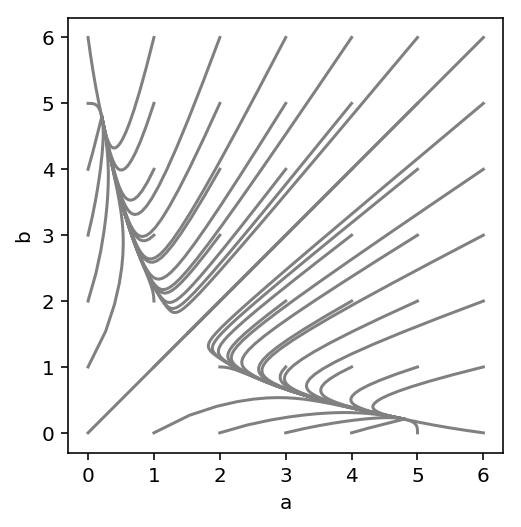

In [5]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

for a0 in range(7):
    for b0 in range(7):
        ab = scipy.integrate.odeint(toggle, np.array([a0, b0]), t, args=args)
        ax.plot(*ab.transpose(), color='gray');

In [6]:
def plot_flow_field(ax, f, u_range, v_range, args=(), n_grid=100):
    """
    Plots the flow field with line thickness proportional to speed.
    
    Parameters
    ----------
    ax : Matplotlib Axis instance
        Axis on which to make the plot
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    u_range : array_like, shape (2,)
        Range of values for u-axis.
    v_range : array_like, shape (2,)
        Range of values for v-axis.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
    
    # Set up u,v space
    u = np.linspace(u_range[0], u_range[1], n_grid)
    v = np.linspace(v_range[0], v_range[1], n_grid)
    uu, vv = np.meshgrid(u, v)

    # Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = f(np.array([uu[i,j], vv[i,j]]), None, *args)

    # Compute speed
    speed = np.sqrt(u_vel**2 + v_vel**2)

    # Make linewidths proportional to speed,
    # with minimal line width of 0.5 and max of 3
    lw = 0.5 + 2.5 * speed / speed.max()

    # Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel, linewidth=lw, arrowsize=1.2, 
                  density=1, color='thistle')

    return ax

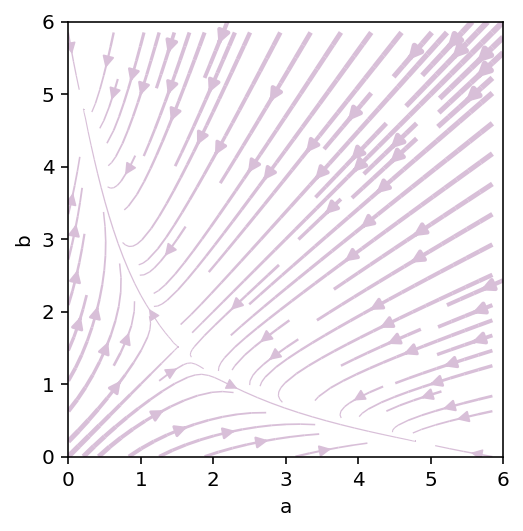

In [7]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

ax = plot_flow_field(ax, toggle, (0, 6), (0, 6), args=args)

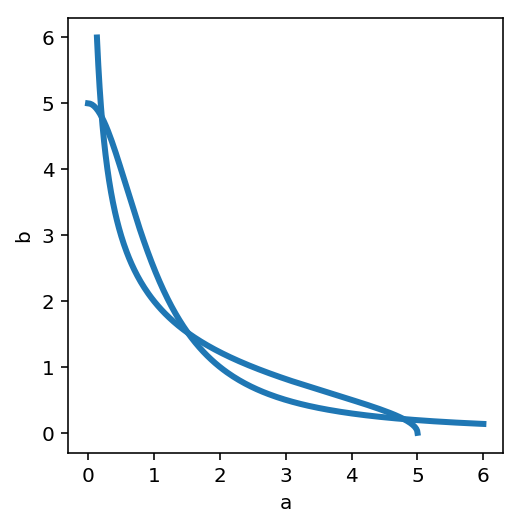

In [8]:
def plot_null_clines_toggle(ax, a_range, b_range, beta, gamma, n, 
                            colors=['#1f77b4', '#1f77b4'], lw=3):
    """Add nullclines to ax."""
    # a-nullcline
    nca_b = np.linspace(b_range[0], b_range[1], 200)
    nca_a = beta / (1 + nca_b**n)

    # b-nullcline
    ncb_a = np.linspace(a_range[0], a_range[1], 200)
    ncb_b = beta / (1 + ncb_a**n)

    # Plot
    ax.plot(nca_a, nca_b, lw=lw, color=colors[0])
    ax.plot(ncb_a, ncb_b, lw=lw, color=colors[1])
    
    return ax
    
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')
ax = plot_null_clines_toggle(ax, [0, 6], [0, 6], beta, gamma, n)

In [9]:
def fp_toggle(beta, gamma, n):
    """Return fixed points of toggle."""
    # Find unstable fixed point
    coeffs = np.zeros(n+2)
    coeffs[0] = 1
    coeffs[-2] = 1
    coeffs[-1] = -beta
    r = np.roots(coeffs)
    ind = np.where(np.logical_and(np.isreal(r), r.real >= 0))
    fp1 = np.array([r[ind][0].real]*2)

    # Return single fixed point is only one
    if n < 2 or beta <= n/(n-1)**(1+1/n):
        return (fp1,)
    
    # Compute other fixed points
    def fp_fun(ab):
        a, b = ab
        return np.array([beta / (1 + b**n), beta / (1 + a**n)])
    fp0 = scipy.optimize.fixed_point(fp_fun, [0, 1])
    fp2 = fp0[::-1]
    
    return (fp0, fp1, fp2)

In [10]:
def plot_fixed_points_toggle(ax, beta, gamma, n):
    """Add fixed points to plot."""
    # Compute fixed points
    fps = fp_toggle(beta, gamma, n)
    
    # Plot
    if len(fps) == 1:
        ax.plot(*fps[0], '.', color='black', markersize=20)
    else:
        ax.plot(*fps[0], '.', color='black', markersize=20)
        ax.plot(*fps[1], '.', markerfacecolor='white', markeredgecolor='black', 
                markeredgewidth=2, markersize=20)
        ax.plot(*fps[2], '.', color='black', markersize=20)

    return ax

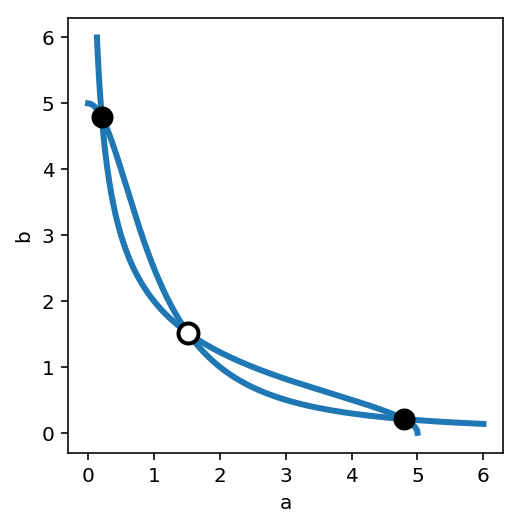

In [11]:
ax = plot_fixed_points_toggle(ax, beta, gamma, n)
fig

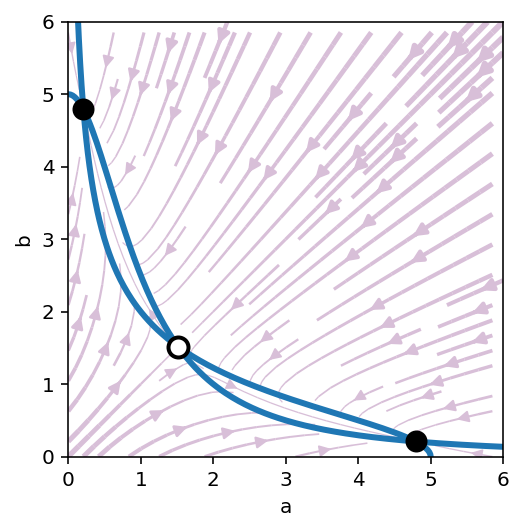

In [12]:
# Set up the figure
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

# Build the plot
a_range = [0, 6]
b_range = [0, 6]
ax = plot_flow_field(ax, toggle, a_range, b_range, args=args)
ax = plot_null_clines_toggle(ax, a_range, b_range, beta, gamma, n)
ax = plot_fixed_points_toggle(ax, beta, gamma, n)

In [13]:
def plot_traj(ax, f, y0, t, args=(), color='black', lw=2):
    """
    Plots a trajectory on a phase portrait.
    
    Parameters
    ----------
    ax : Matplotlib Axis instance
        Axis on which to make the plot
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    y0 : array_like, shape (2,)
        Initial condition.
    t : array_like
        Time points for trajectory.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
    
    y = scipy.integrate.odeint(f, y0, t, args=args)
    ax.plot(*y.transpose(), color=color, lw=lw)
    return ax

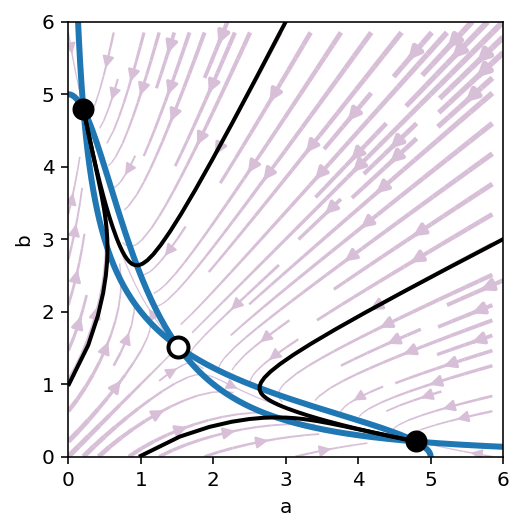

In [14]:
ax = plot_traj(ax, toggle, np.array([0.01, 1]), t, args=args)
ax = plot_traj(ax, toggle, np.array([1, 0.01]), t, args=args)
ax = plot_traj(ax, toggle, np.array([3, 6]), t, args=args)
ax = plot_traj(ax, toggle, np.array([6, 3]), t, args=args)
fig

In [15]:
def plot_separatrix_toggle(ax, a_range, b_range, beta, gamma, n, t_max=30, eps=1e-6, 
                           color='tomato', lw=3):
    """
    Plot separatrix on phase portrait.
    """
    # Compute fixed points
    fps = fp_toggle(beta, gamma, n)
    
    # If only one fixed point, no separatrix
    if len(fps) == 1:
        return ax
    
    # Negative time function to integrate to compute separatrix
    def rhs(ab, t):
        # Unpack variables
        a, b = ab
    
        # Stop integrating if we get the edge of where we want to integrate
        if a_range[0] < a < a_range[1] and b_range[0] < b < b_range[1]:
            return -toggle(ab, t, beta, gamma, n)
        else:
            return np.array([0, 0])

    # Parameters for building separatrix
    t = np.linspace(0, t_max, 400)

    # Build upper right branch of separatrix
    ab0 = fps[1] + eps
    ab_upper = scipy.integrate.odeint(rhs, ab0, t)

    # Build lower left branch of separatrix
    ab0 = fps[1] - eps
    ab_lower = scipy.integrate.odeint(rhs, ab0, t)

    # Concatenate, reversing lower so points are sequential
    sep_a = np.concatenate((ab_lower[::-1,0], ab_upper[:,0]))
    sep_b = np.concatenate((ab_lower[::-1,1], ab_upper[:,1]))
    
    # Plot
    ax.plot(sep_a, sep_b, '-', color=color, lw=lw)
    
    return ax

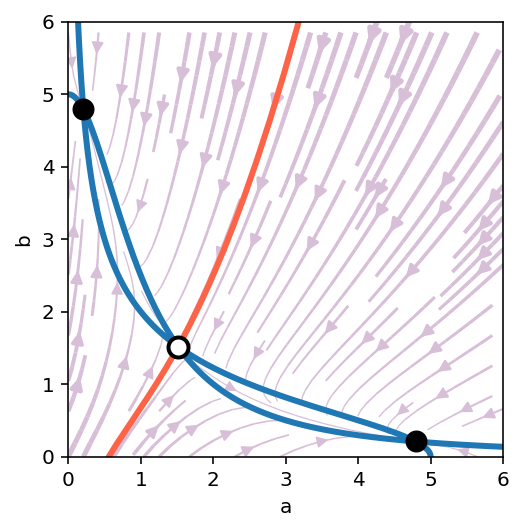

In [16]:
# Parameters
gamma = 2
beta = 5
n = 2
args = (beta, gamma, n)

# Set up the figure
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

# Build the plot
a_range = [0, 6]
b_range = [0, 6]
ax = plot_flow_field(ax, toggle, a_range, b_range, args=args)
ax = plot_null_clines_toggle(ax, a_range, b_range, beta, gamma, n)
ax = plot_separatrix_toggle(ax, a_range, b_range, beta, gamma, n)
ax = plot_fixed_points_toggle(ax, beta, gamma, n)

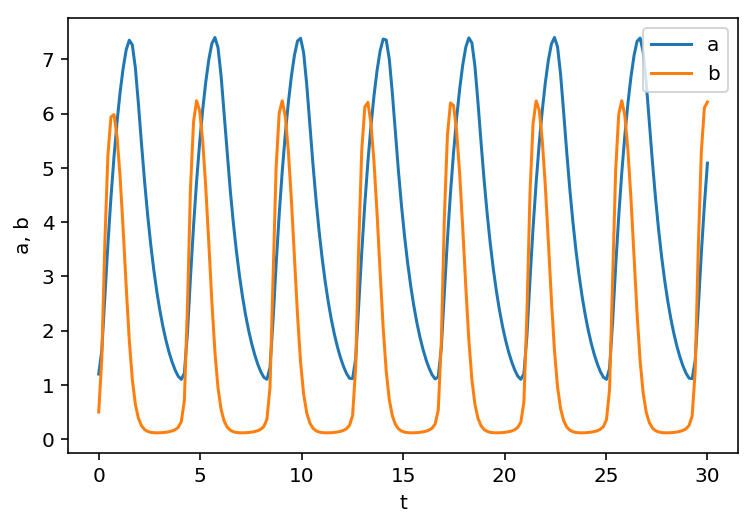

In [17]:
def act_rep_clock(ab, t, alpha, beta, gamma, n):
    """Right hand side of ODEs for activator-repressor clock."""
    a, b = ab
    return np.array([alpha + beta * b**n / (1 + b**n) - a,
                     gamma * (alpha + beta * b**n / (1 + a**n + b**n) - b)])

beta = 10 
alpha = 0.1
gamma = 5
n = 2
args = (alpha, beta, gamma, n)

# Solve
t = np.linspace(0, 30, 200)
ab0 = np.array([1.2, 0.5])
ab = scipy.integrate.odeint(act_rep_clock, ab0, t, args=args)

# Plot
plt.plot(t, ab)
plt.xlabel('t')
plt.ylabel('a, b')
plt.legend(('a', 'b'));

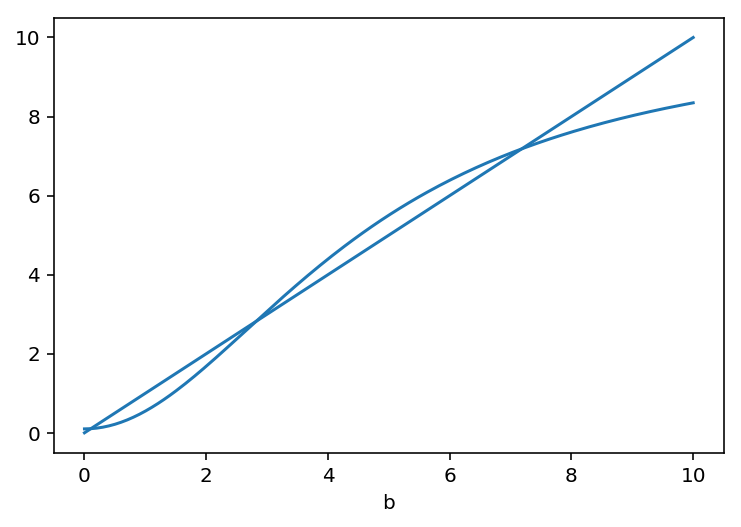

In [18]:
a = 4.5
b = np.linspace(0, 10, 200)
plt.plot(b, b)
plt.plot(b, alpha + beta * b**n / (1 + a**n + b**n), color=colors[0])
plt.xlabel('b');

In [19]:
def b_nullcline(a_vals, b_range):
    """Find b-nullcline for values of a."""
    # Set up output array
    b_nc = np.empty((len(a_vals), 3))
    b = np.linspace(b_range[0], b_range[1], 10000)
    
    # For each value of a, find where rhs of ODE is zero
    for i, a in enumerate(a_vals):
        s = np.sign(alpha + beta * b**n / (1 + a**n + b**n) - b)

        # Values of b for sing switches
        b_vals = b[np.where(np.diff(s))]

        # Make sure we put numbers in correct branch
        if len(b_vals) == 0:
            b_nc[i,:] = np.array([np.nan, np.nan, np.nan])
        elif len(b_vals) == 1:
            if b_vals[0] > 2*alpha:
                b_nc[i,:] = np.array([np.nan, np.nan, b_vals[0]])
            else:
                b_nc[i,:] = np.array([b_vals[0], np.nan, np.nan])
        elif len(b_vals) == 2:
            b_nc[i,:] = np.array([b_vals[0], b_vals[1], np.nan])
        else:
            b_nc[i,:] = b_vals

    return b_nc

In [20]:
def plot_null_clines_act_rep_clock(ax, a_range, b_range, alpha, beta, gamma, n, 
                                   colors=['#1f77b4', '#1f77b4'], lw=3):
    """Add nullclines to ax."""
    # a-nullcline
    nca_b = np.linspace(b_range[0], b_range[1], 200)
    nca_a = alpha + beta * nca_b**n / (1 + nca_b**n)

    # b-nullcline
    ncb_a = np.linspace(a_range[0], a_range[1], 20000)
    ncb_b = b_nullcline(ncb_a, b_range)

    # Plot
    ax.plot(nca_a, nca_b, lw=lw, color=colors[0])
    ax.plot(ncb_a, ncb_b, lw=lw, color=colors[1])
    
    return ax

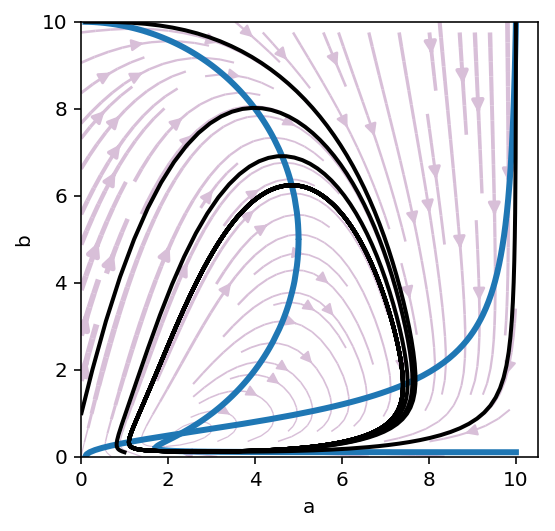

In [21]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')

t = np.linspace(0, 15, 400)
ax = plot_flow_field(ax, act_rep_clock, [0, 10], [0, 10], args=args)
ax = plot_null_clines_act_rep_clock(ax, [0, 10], [0, 10], alpha, beta, gamma, n)
ax = plot_traj(ax, act_rep_clock, np.array([0.01, 1]), t, args=args)
ax = plot_traj(ax, act_rep_clock, np.array([0.1, 10]), t, args=args)
ax = plot_traj(ax, act_rep_clock, np.array([1, 0.1]), t, args=args)
ax = plot_traj(ax, act_rep_clock, np.array([10, 10]), t, args=args)